# Wildfire Susceptibility mapping

**Abstract**

Table of Contents : 

- [Preprocessing]()

## Libraries

In [1]:
import numpy as np 
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_rows', 4)

## Preprocessing

In [2]:
LAND_COVER_PATH = 'data/land_cover_2000/U2006_CLC2000_V2020_20u1.tif'
DEM_PATH_v1 = 'data/dem/eu_dem_v11_E30N20.TIF'
DEM_PATH_V0 = 'data/dem_v00/EUD_CP-DEMS_3500025000-AA.tif'
DEM_REPROJ_PATH = 'data/dem_v00/dem_reproj.tif'
DEM_REPROJ_RES_PATH = 'data/dem_v00/dem_test.tif'
VEGETATION_PATH = 'data/'
BURNT_AREAS_PATH = 'data/burnt_areas/modis.ba.poly.shp'
PROTECTED_AREAS_PATH = 'data/ens/ens.shp'
CONTOURS_PATH = 'data/contours/departements-20180101.shp'
SLOPE_PATH = 'data/slope/EUD_CP-SLOP_3500025000-AA.tif'
SLOPE_REPROJ_PATH = 'data/slope/sl_test.tif'

In [3]:
import geopandas as gpd
import shapely.geometry
import shapely.wkt

import rasterio 
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.features import rasterize

import subprocess

# CRS transformations
import pyproj

# raster operations
import os
from osgeo import gdal

import rasterio.mask 
import rasterstats
import math

### Contouring

In [4]:
contours = gpd.read_file(CONTOURS_PATH)

In [5]:
contours.shape

(102, 6)

In [6]:
contours.head()

,code_insee,nom,nuts3,wikipedia,surf_km2,geometry
0,974,La RÃ©union,FR940,fr:La RÃ©union,2505.0,"MULTIPOLYGON (((55.21643 -21.03904, 55.21652 -..."
1,11,Aude,FR811,fr:Aude (dÃ©partement),6343.0,"POLYGON ((1.68872 43.27368, 1.69001 43.27423, ..."
...,...,...,...,...,...,...
3,13,Bouches-du-RhÃ´ne,FR823,fr:Bouches-du-RhÃ´ne,5247.0,"MULTIPOLYGON (((4.23014 43.46047, 4.23025 43.4..."
4,47,Lot-et-Garonne,FR614,fr:Lot-et-Garonne,5385.0,"POLYGON ((-0.14058 44.22648, -0.12931 44.23218..."


<AxesSubplot: >

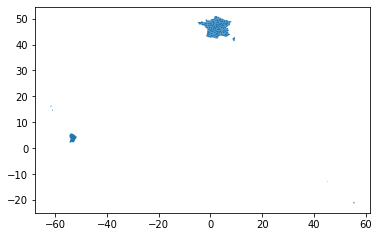

In [7]:
contours.plot()

We will use the department number to select the regions of interest : in this case, Pyrénées-Atlantiques (64) and Hautes-Pyrénées (65).

<AxesSubplot: >

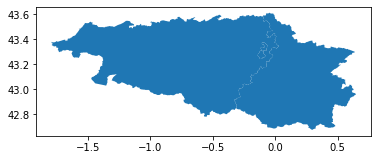

In [8]:
pyrenees = contours[(contours.code_insee == '64') | (contours.code_insee == '65')]
pyrenees.plot()

An important information to note is that the CRS used is the WGS 84: as we are in 2D, the CRS is commonly named EPSG 4326.

### Slope
With the help of QGIS application, we performed the necessary transformation to simplify the CRS of the slope and DEM rasters.

In [9]:
slope_reproj = rasterio.open(SLOPE_REPROJ_PATH)
slope = rasterio.open(SLOPE_PATH)

In [10]:
slope.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 40000,
 'height': 40000,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["JRC-EGCS",GEOGCS["ETRS89",DATUM["unnamed",SPHEROID["GRS 1980",6378137,298.257222100004]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(25.0, 0.0, 3000000.0,
        0.0, -25.0, 3000000.0)}

In [11]:
slope_reproj.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10000,
 'height': 10000,
 'count': 1,
 'crs': CRS.from_wkt('LOCAL_CS["ETRS89-extended / LAEA Europe",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(100.0, 0.0, 3000000.0,
        0.0, -100.0, 3000000.0)}

### Digital Elevation Model

In [12]:
%%time

# open a connection to the raster
dem = rasterio.open(DEM_PATH_V0)
dem_reproj = rasterio.open(DEM_REPROJ_PATH)
dem_test = rasterio.open(DEM_REPROJ_RES_PATH)

Wall time: 21.9 ms


In [13]:
# plot the raster
show(dem)

KeyboardInterrupt: 

In [13]:
# raster metadata
dem.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 40000,
 'height': 40000,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["JRC-EGCS",GEOGCS["ETRS89",DATUM["unnamed",SPHEROID["GRS 1980",6378137,298.257222100004]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(25.0, 0.0, 3000000.0,
        0.0, -25.0, 3000000.0)}

In [14]:
dem_reproj.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 40000,
 'height': 40000,
 'count': 1,
 'crs': CRS.from_wkt('LOCAL_CS["ETRS89-extended / LAEA Europe",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(25.0, 0.0, 3000000.0,
        0.0, -25.0, 3000000.0)}

In [15]:
dem_test.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 10000,
 'height': 10000,
 'count': 1,
 'crs': CRS.from_wkt('LOCAL_CS["ETRS89-extended / LAEA Europe",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(100.0, 0.0, 3000000.0,
        0.0, -100.0, 3000000.0)}

In [16]:
land_cov_2000.meta

NameError: name 'land_cov_2000' is not defined

The metadata of the raster file give us important informations : the CRS used is the ETRS_1989 or EPSG 3035 if we use the EPSG classification. The unit used is the meter, its resolution is 25x25 meters with the origin starting at (3000000.0, 3000000.0) in its corresponding CRS.  
The land cover raster had a resolution of 100x100 meters, therefore we need to aggregate the values of four non-overlapping  adjacent cells to obtain the same resolution. With the help of QGIS application, we have reprojected DEM and slope data so that it is recognized by the ESPG registry. It will help us merge the transform of the different rasters.  

In [ ]:
%%time
# we have used Qgis and gdal to perform the projections and change of resolutions 
'''
# change the resolution, transform and crs of dem data to match land cover metadata
# use rasterio.reproject() using the same crs as src and dst

with rasterio.open(DEM_PATH) as src_dem:
    print(type(src_dem))
    
    # transform for input raster
    src_transform = src_dem.transform
    # dem crs not recognized by rasterio : we assume that land cover and dem data have the same crs : epsg 3035
    dst_crs = land_cov.crs
    src_crs = land_cov.crs
    
    # calculate the transform matrix for the output
    dst_transform, width, height = calculate_default_transform(
        dst_crs,    # source CRS
        dst_crs,    # destination CRS
        src_dem.width,    # column count
        src_dem.height,  # row count
        *src_dem.bounds,  # unpacks outer boundaries (left, bottom, right, top)
    )
    
    # set properties for output
    dst_kwargs = src_dem.meta.copy()
    dst_kwargs.update(
        {
            "crs": dst_crs,
            "transform": dst_transform,
            "width": width,
            "height": height,
            "nodata": land_cov.meta['nodata'], 
        }
    )
    
    print(src_dem.meta)
    
    with rasterio.open("dem_reproj", "w", **dst_kwargs) as dst:
        reproject(
            source = src_dem,
            destination = dst,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)'''

### Land Cover

In [67]:
# 2000 land_cover data
land_cov_2000 = rasterio.open(LAND_COVER_PATH)

In [ ]:
# visualize with QGIS: memory problem
show(land_cov_2000)

In [18]:
land_cov_2000.meta

{'driver': 'GTiff',
 'dtype': 'int8',
 'nodata': -128.0,
 'width': 65000,
 'height': 46000,
 'count': 1,
 'crs': CRS.from_wkt('LOCAL_CS["ETRS_1989_LAEA",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(100.0, 0.0, 900000.0,
        0.0, -100.0, 5500000.0)}

The metadata of the raster file give us important informations : the CRS used is the ETRS_1989 or EPSG 3035 if we use the EPSG classification. The unit used is the meter, its resolution is 100x100 meters with the origin starting at (900000.0, 900000.0) in its corresponding CRS.

In [19]:
# the memory footprint of the raster seems heavy, thus we will need to mask the data using the contours shapefile we have seen previously
layer_cov = land_cov_2000.read(1)

KeyboardInterrupt: 

In [20]:
land_cov_2000.meta

{'driver': 'GTiff',
 'dtype': 'int8',
 'nodata': -128.0,
 'width': 65000,
 'height': 46000,
 'count': 1,
 'crs': CRS.from_wkt('LOCAL_CS["ETRS_1989_LAEA",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(100.0, 0.0, 900000.0,
        0.0, -100.0, 5500000.0)}

In [21]:
dem_test.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 10000,
 'height': 10000,
 'count': 1,
 'crs': CRS.from_wkt('LOCAL_CS["ETRS89-extended / LAEA Europe",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(100.0, 0.0, 3000000.0,
        0.0, -100.0, 3000000.0)}

Now we need to crop the raster file to the area of interest in the study that is the pyrenees dataframe we have previously defined.  
First we need to convert the CRS of the contours vector into the CRS of land cover/dem rasters.  
For simplicity, we consider that the land cover/dem have the same crs EPSG:3035 (ETRS89-LAEA)

In [23]:
# affine transform of vector shapes ?

pyrenees_proj = pyrenees.to_crs(epsg='3035')

land_cover_mask, land_cover_transform_mask = rasterio.mask.mask(
    land_cov_2000, 
    pyrenees_proj.geometry, 
    crop=True, 
    nodata=land_cov_2000.meta['nodata']
)

dem_mask, dem_transform_mask = rasterio.mask.mask(
    dem_test, 
    pyrenees_proj.geometry,
    crop=True, 
    nodata=dem_test.meta['nodata']
)

slope_mask, slope_transform_mask = rasterio.mask.mask(
    slope_reproj, 
    pyrenees_proj.geometry,
    crop=True, 
    nodata=slope_reproj.meta['nodata']
)

# TODO: homegeneise land cover and dem data beforehand 
print('LAND COVER CROPPING')
print(land_cover_mask.squeeze().shape)
print(land_cover_transform_mask)

print('\nDEM CROPPING')
print(dem_mask.squeeze().shape)
print(dem_transform_mask)

print('\nSLOPE CROPPING')
print(slope_mask.squeeze().shape)
print(slope_transform_mask)

LAND COVER CROPPING
(1157, 1944)
| 100.00, 0.00, 3367000.00|
| 0.00,-100.00, 2341200.00|
| 0.00, 0.00, 1.00|

DEM CROPPING
(1157, 1944)
| 100.00, 0.00, 3367000.00|
| 0.00,-100.00, 2341200.00|
| 0.00, 0.00, 1.00|

SLOPE CROPPING
(1157, 1944)
| 100.00, 0.00, 3367000.00|
| 0.00,-100.00, 2341200.00|
| 0.00, 0.00, 1.00|


### Burnt Areas

TODO: EDA on this file

We will use this file to label the areas of interest in this study. First we will perform an exploratory data analysis to give us insights on the nature of the data.

In [39]:
burnt = gpd.read_file(BURNT_AREAS_PATH)

In [40]:
burnt.shape

(62822, 19)

In [41]:
burnt[burnt.COUNTRY=='FR'].count()

# EDA : 
# plot total number of fires per country 
# plot total number of fires per year  

id          3158
FIREDATE    3158
            ... 
CLASS       3158
geometry    3158
Length: 19, dtype: int64

<AxesSubplot: >

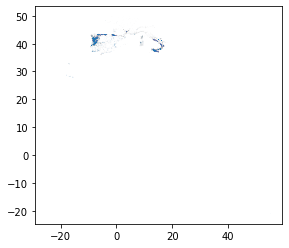

In [42]:
burnt[(burnt.COUNTRY == 'IT') | (burnt.COUNTRY == 'PT') |
     (burnt.COUNTRY == 'ES') | (burnt.COUNTRY == 'FR')].plot()

In [43]:
burnt['geometry'].type.value_counts()

Polygon         61707
MultiPolygon     1115
dtype: int64

In [44]:
burnt['geometry'].crs

{'init': 'epsg:4326'}

We see that the shapefile is in different Coordinate Reference System than land cover and digital elevation model data (coming from Copernicus sources). The next step is to project this shapefile from CRS EPSG 4236 to EPSG 3035.

In [45]:
# We restrict the shapefile to fires happening in France 
burnt_pyrenees = burnt[(burnt.COUNTRY=='FR') & (burnt.PROVINCE=='Hautes-Pyrénées') | (burnt.PROVINCE == 'Pyrénées-Atlantiques')]


# change crs to espg 3035
burnt_pyrenees = burnt_pyrenees.to_crs(epsg='3035')

# we extract the year of the firedate and change the type to int
burnt_pyrenees['YEAR'] = burnt_pyrenees['FIREDATE'].apply(lambda d: int(d[:4]))
burnt_pyrenees.head()

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,SCLEROPH,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry,YEAR
3523,178793,2001-12-25 00:00:00,2001-12-25 00:00:00,FR,Pyrénées-Atlantiques,Sainte-Engrâce,17,99.999999999375,0,0,0,0,0,0,0,0,2.1781429291483865,FireSeason,"POLYGON ((3438525.283 2272578.578, 3438880.513...",2001
3612,178973,2001-12-25 00:00:00,2001-12-27 00:00:00,FR,Pyrénées-Atlantiques,Lanne-en-Barétous,70,1.4285714285693878,69.9999999999,25.71428571424898,0,0,2.8571428571387756,0,0,0,4.115763973318598,FireSeason,"POLYGON ((3441180.296 2276133.481, 3440470.228...",2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3822,30231,2002-01-01 00:00:00,2002-01-01 00:00:00,FR,Pyrénées-Atlantiques,Tardets-Sorholus,525,19.011406844102847,4.372623574143655,0,0,0,65.01901140683174,11.596958174902737,0,0,0.7337047692039197,FireSeason,"POLYGON ((3441207.794 2288728.781, 3441189.152...",2002
3994,30543,2002-01-01 00:00:00,2002-01-01 00:00:00,FR,Pyrénées-Atlantiques,Ascain,176,20.454545454533836,0,0,0,0,74.9999999999574,3.409090909088972,1.1363636363629908,0,5.2270921294597805,FireSeason,"POLYGON ((3378629.527 2321046.477, 3378609.433...",2002


The next step is to rasterize the burnt areas shapefile with the same resolution as the other rasters i.e 100x100m, in the same CRS i.e EPSG 3035.

In [65]:
print(pyrenees_proj.total_bounds)
print(burnt_pyrenees.total_bounds)

[3367045.56860202 2225527.26600656 3561342.78155953 2341146.00704033]
[3370329.21071314 2230008.19838224 3553204.79441611 2325000.49717843]


TypeError: from_origin() missing 4 required positional arguments: 'west', 'north', 'xsize', and 'ysize'

In [ ]:
burnt_proj = burnt.to_crs(epsg='3035')

In [76]:
# rasterize the burnt areas to combine it with other rasters
# partition the fire date depending on the dates on the available land cover data
print(burnt_pyrenees.total_bounds)
# print(burnt.to_crs(epsg='3035').total_bounds)
# print(land_cov_2000.transform)
# print(slope_transform_mask)


bounds = burnt_proj.total_bounds
res = 100

transform = rasterio.transform.from_origin(
    west=bounds[0], 
    north=bounds[3], 
    xsize=res, 
    ysize=res
)

rows = math.ceil((bounds[3] - bounds[1]) / res)
cols = math.ceil((bounds[2] - bounds[0]) / res)
shape = (rows, cols)

print(shape)

burnt_areas_raster = rasterio.features.rasterize(
    ((g, 1) for g in burnt_proj['geometry'].to_list()),
    out_shape=shape,
    transform=transform
)

print(burnt_areas_raster.meta)

burnt_area_mask, burnt_area_transform_mask = rasterio.mask.mask(
    burnt_areas_raster, 
    pyrenees_proj.geometry, 
    crop=True, 
    nodata=burnt_areas_raster.meta['nodata']
)

'''for g in burnt['geometry'].tolist():
    print((1, g))
'''

[3370329.21071314 2230008.19838224 3553204.79441611 2325000.49717843]


NameError: name 'burnt_proj' is not defined

### Protected Areas (France)

In [69]:
protected = gpd.read_file(PROTECTED_AREAS_PATH)

In [70]:
protected.head()

,OBJECTID,ID_LOCAL,ID_MNHN,NOM_SITE,DATE_CREA,MODIF_ADM,MODIF_GEO,URL_FICHE,SURF_OFF,ACTE_DEB,...,P10_PUBLIC,P11_DD,P12_AUTRE,ID_TECH,SURF_SIG,CODE_TERRI,STATUT_FON,SHAPE_AREA,SHAPE_LEN,geometry
0,1,None,FR4700001,None,None,None,None,None,0.0,None,...,None,None,None,29_01,0.564999,000,None,0.0,0.0,"MULTIPOLYGON (((199437.759 6763968.161, 199433..."
1,2,None,FR4700002,None,None,None,None,None,0.0,None,...,None,None,None,29_02,55.937425,000,None,0.0,0.0,"MULTIPOLYGON (((135017.696 6857815.407, 135019..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,4,None,FR4700004,None,None,None,None,None,0.0,None,...,None,None,None,29_04,39.168999,000,None,0.0,0.0,"MULTIPOLYGON (((145131.796 6863931.431, 145133..."
4,5,None,FR4700005,None,None,None,None,None,0.0,None,...,None,None,None,29_05,0.406897,000,None,0.0,0.0,"POLYGON ((185215.026 6772626.016, 185215.365 6..."


<AxesSubplot: >

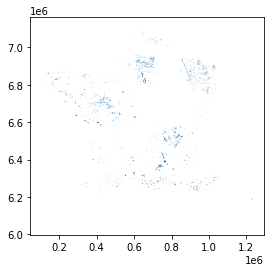

In [71]:
protected.plot()

In [72]:
protected['geometry'].crs

{'proj': 'lcc',
 'lat_1': 44,
 'lat_2': 49,
 'lat_0': 46.5,
 'lon_0': 3,
 'x_0': 700000,
 'y_0': 6600000,
 'ellps': 'GRS80',
 'units': 'm',
 'no_defs': True}

In [73]:
dem_reproj.crs

CRS.from_wkt('LOCAL_CS["ETRS89-extended / LAEA Europe",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

<AxesSubplot: >

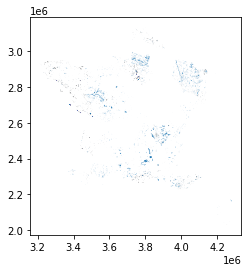

In [74]:
protected.to_crs(epsg='3035').plot()

### Vegetation